# Vehicle Detection


## The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
# Define all imports upfront
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from moviepy.editor import VideoFileClip
import random
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import pickle
import os.path
import time


# Our utils
from im_utils import read_cv2_image, read_mpimg
from transforms import bin_spatial, extract_features, \
color_hist, get_hog_features, find_cars, \
draw_bounding_boxes, add_heat, apply_threshold, get_labels, draw_labeled_bboxes, run_sliding_window

## Step1 - Data Exploration

In [2]:
vehicle_paths = glob.glob('dataset/vehicles/**/*.png')
non_vehicle_paths =  glob.glob('dataset/non-vehicles/**/*.png')

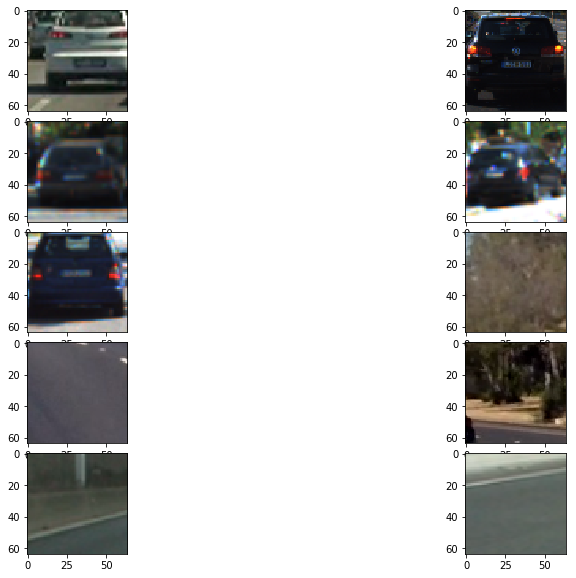

In [3]:
def get_random_vehicle_images(num):
    images = []
    rand_vehicle_indices = random.sample(range(len(vehicle_paths)), num)
    for i in rand_vehicle_indices:
        images.append(read_mpimg(vehicle_paths[i]))
    return images

def get_random_non_vehicle_images(num):
    images = []
    rand_non_car_indices = random.sample(range(len(non_vehicle_paths)), num)
    for i in rand_non_car_indices:
        images.append(read_mpimg(non_vehicle_paths[i]))
    return images
    
    
def explore_images():
    images = get_random_vehicle_images(5)
    images.extend(get_random_non_vehicle_images(5))    
    fig, axs = plt.subplots(5, 2, figsize=(15, 10))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    for i in range(10):
        img = images[i]
        axs[i].imshow(img)
                             
explore_images()                             

## Step2 - Transformations and training pipeline

### Step 2.1 - Visualize Hog transformation

In [4]:
# Get some reandom images and run them against `get_hog_features` method with 
# visualization and see how our tranform is working

def visualize_hog(orient=9, pix_per_cell=8, cell_per_block=2):        
    random_vehicles = get_random_vehicle_images(5)
    fig, axs = plt.subplots(5, 4, figsize=(15, 10))
    fig.subplots_adjust(hspace = .3, wspace=.1)
    axs = axs.ravel()

    i = 0

    orient=9 
    pix_per_cell=8
    cell_per_block=2

    while i < 20:
        vehicle = random_vehicles[int(i/4)]
        _, hog_ch1 = get_hog_features(vehicle[:,:,0], 
                                      orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, vis=True, feature_vec=True)
        _, hog_ch2 = get_hog_features(vehicle[:,:,1], 
                                      orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, vis=True, feature_vec=True)
        _, hog_ch3 = get_hog_features(vehicle[:,:,2], 
                                      orient=orient, 
                                      pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, vis=True, feature_vec=True)
        axs[i].imshow(vehicle)
        axs[i].set_title('Vehicle')    
        i +=1

        axs[i].imshow(hog_ch1,  cmap='gray')
        axs[i].set_title('hog_ch1')
        i +=1

        axs[i].imshow(hog_ch2,  cmap='gray')
        axs[i].set_title('hog_ch2')
        i +=1

        axs[i].imshow(hog_ch3, cmap='gray')
        axs[i].set_title('hog_ch3')
        i +=1


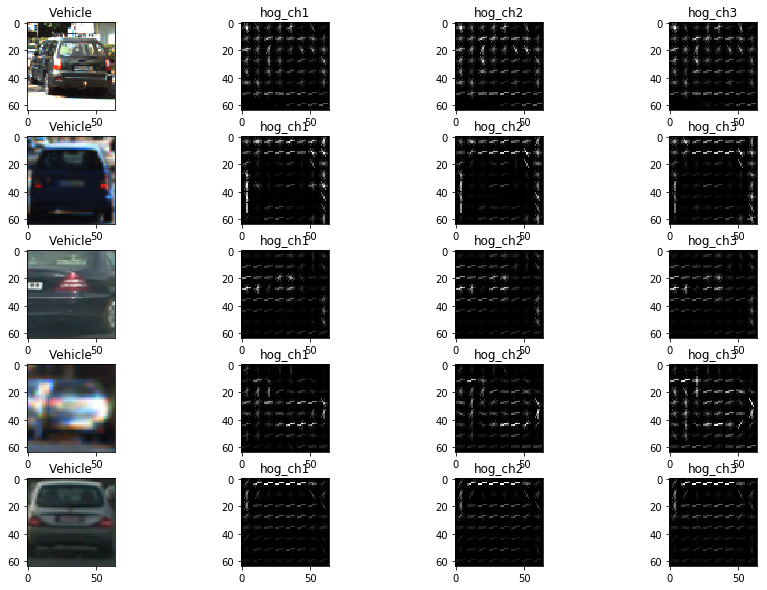

In [5]:
visualize_hog()

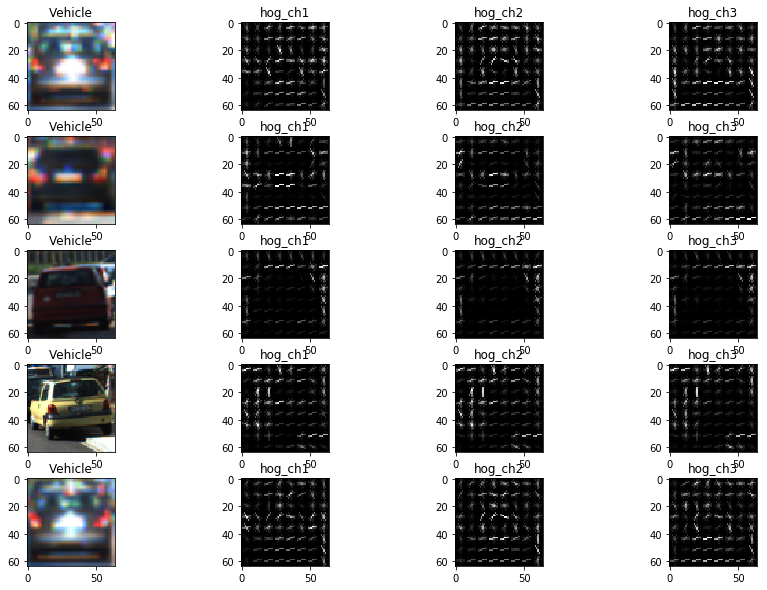

In [6]:
visualize_hog(orient=11)

### Step 2.2 - Define a Tranining Pipeline

Here I define `training_pipeline` function which 
1. Constructs feature and label vectors from car and non car test image set
2. Performs feature normalization using `StandardScaler` from sklearn
3. Using `train_test_split` from sklearn split data into training and validation sets
4. Using `LinearSVC` as suggested in class train the model
5. Method returns a tuple => (model, accuracy, training_time, X_scaler)

In [7]:
def training_pipeline(test_car_images, test_non_car_images,
                     cspace='RGB', spatial_size=(32, 32),
                     spatial_transform=True, hist_transform=True, hist_bins=32,
                     hog_transform=True, pix_per_cell=8, cell_per_block=2, orient=9,
                     hog_channel='ALL'):
    
    start_time=time.time()
    car_features = extract_features(test_car_images, cspace=cspace, spatial_size=spatial_size,
                                    spatial_transform=spatial_transform, hist_transform=hist_transform, 
                                    hist_bins=hist_bins, hog_transform=hog_transform, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                    orient=orient, hog_channel=hog_channel)

    not_car_features = extract_features(test_non_car_images, cspace=cspace, spatial_size=spatial_size,
                                    spatial_transform=spatial_transform, hist_transform=hist_transform, 
                                    hist_bins=hist_bins, hog_transform=hog_transform, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                    orient=orient, hog_channel=hog_channel)

    # Stack feature vectors
    X = np.vstack((car_features, not_car_features)).astype(np.float64)                        

    # Combine car and non labels into one feature vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
    
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    # Shuffle and split data to training and test. 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

    svc = LinearSVC()
    svc.fit(X_train, y_train)
    
    # Compute training time
    training_time=round(time.time()-start_time, 3)
    
    # Get training accuracy
    training_accuracy=round(svc.score(X_test, y_test), 3)
    
    return (svc, training_accuracy, training_time, X_scaler)
    

In [8]:
vehicle_images = []
non_vehicle_images = []
for i in range(len(vehicle_paths)):
        vehicle_images.append(read_mpimg(vehicle_paths[i]))

for i in range(len(non_vehicle_paths)):
        non_vehicle_images.append(read_mpimg(non_vehicle_paths[i]))

print("Number of vehicle images:", len(vehicle_images))        
print("Number of non vehicle images:", len(non_vehicle_images)) 

Number of vehicle images: 8792
Number of non vehicle images: 8968


### Step 2.3 - Test various parameter configurations


In [9]:
def test_parameters(option_dict):
    cspace=option_dict.get('cspace','RGB')
    spatial_size=option_dict.get('spatial_size',(32, 32))
    spatial_transform=option_dict.get('spatial_transform', True)
    
    hist_transform=option_dict.get('hist_transform', True)
    hist_bins=option_dict.get('hist_bins',32)
    
    hog_transform=option_dict.get('hog_transform',True)
    orient=option_dict.get('orient', 9)
    pix_per_cell=option_dict.get('pix_per_cell', 8)
    cell_per_block=option_dict.get('cell_per_block',2)
    hog_channel=option_dict.get('hog_channel', 1)
    
    _, training_accuracy, training_time, _ = training_pipeline(vehicle_images, non_vehicle_images,
                     cspace=cspace, spatial_size=spatial_size,
                     spatial_transform=spatial_transform, hist_transform=hist_transform, hist_bins=hist_bins,
                     hog_transform=hog_transform, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                     orient=orient, hog_channel=hog_channel)
    
    print("Option dict \n", option_dict)
    print("Training accuracy {}, Training time {} seconds".format(training_accuracy, training_time))


In [10]:
    
print("===================================== Params: 1 =======================================")
test_parameters({
    'cspace': 'RGB',
    'spatial_size':(32, 32),
    'spatial_transform': True, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL'
})

===================================== Params: 1 =======================================
Option dict 
 {'spatial_size': (32, 32), 'hist_transform': True, 'hog_channel': 'ALL', 'cspace': 'RGB', 'hist_bins': 32, 'hog_transform': True, 'spatial_transform': True, 'cell_per_block': 2, 'pix_per_cell': 8, 'orient': 9}
Training accuracy 0.985, Training time 140.673 seconds


In [11]:
print("===================================== Params: 2 =======================================")
# Accuracy is good but takes a while for training
test_parameters({
    'cspace': 'YCrCb',
    'spatial_size':(32, 32),
    'spatial_transform': True, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL'
})

===================================== Params: 2 =======================================
Option dict 
 {'spatial_size': (32, 32), 'hist_transform': True, 'hog_channel': 'ALL', 'cspace': 'YCrCb', 'hist_bins': 32, 'hog_transform': True, 'spatial_transform': True, 'cell_per_block': 2, 'pix_per_cell': 8, 'orient': 9}
Training accuracy 0.984, Training time 142.21 seconds


In [13]:
print("===================================== Params: 3 =======================================")
# Use only 1 hog channel to see how much time i can save. You can see below, this is much faster but accuracy goes down
test_parameters({
    'cspace': 'YCrCb',
    'spatial_size':(32, 32),
    'spatial_transform': True, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 1
})

===================================== Params: 3 =======================================
Option dict 
 {'cspace': 'YCrCb', 'cell_per_block': 2, 'hist_transform': True, 'hog_channel': 1, 'hist_bins': 32, 'spatial_size': (32, 32), 'spatial_transform': True, 'pix_per_cell': 8, 'orient': 9, 'hog_transform': True}
Training accuracy 0.983, Training time 55.05 seconds


In [14]:
print("===================================== Params: 4 =======================================")
# Use only 1 hog channel and try YUV color space. This does decrease training time but yields lower accuracy.
test_parameters({
    'cspace': 'YUV',
    'spatial_size':(32, 32),
    'spatial_transform': True, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 1
})

===================================== Params: 4 =======================================
Option dict 
 {'cspace': 'YUV', 'cell_per_block': 2, 'hist_transform': True, 'hog_channel': 1, 'hist_bins': 32, 'spatial_size': (32, 32), 'spatial_transform': True, 'pix_per_cell': 8, 'orient': 9, 'hog_transform': True}
Training accuracy 0.972, Training time 60.158 seconds


In [9]:
print("===================================== Params: 5 =======================================")
# Use all 3 hog channels with YUV color space. As you can see, this is reasonably faster and good accuracy.
test_parameters({
    'cspace': 'YUV',
    'spatial_size':(32, 32),
    'spatial_transform': False, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL'
})

===================================== Params: 5 =======================================
Option dict 
 {'spatial_size': (32, 32), 'spatial_transform': False, 'orient': 9, 'hog_transform': True, 'cell_per_block': 2, 'pix_per_cell': 8, 'hist_transform': True, 'hist_bins': 32, 'hog_channel': 'ALL', 'cspace': 'YUV'}
Training accuracy 0.983, Training time 80.278 seconds


In [10]:
print("===================================== Params: 6 =======================================")
# Use all 3 hog channels with YUV color space. Increase orient. This increased time with gain in accuracy
test_parameters({
    'cspace': 'YUV',
    'spatial_size':(32, 32),
    'spatial_transform': False, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 11,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL'
})

===================================== Params: 6 =======================================
Option dict 
 {'spatial_size': (32, 32), 'spatial_transform': False, 'orient': 11, 'hog_transform': True, 'cell_per_block': 2, 'pix_per_cell': 8, 'hist_transform': True, 'hist_bins': 32, 'hog_channel': 'ALL', 'cspace': 'YUV'}
Training accuracy 0.99, Training time 90.899 seconds


In [77]:
print("===================================== Params: 7 =======================================")
# Use config 6 above and remove histogram and spatial transform.
test_parameters({
    'cspace': 'YUV',
    'spatial_size':(32, 32),
    'spatial_transform': False, 
    'hist_transform': False,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 11,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL'
})

===================================== Params: 7 =======================================
Option dict 
 {'hog_transform': True, 'spatial_transform': False, 'cspace': 'YUV', 'orient': 11, 'spatial_size': (32, 32), 'pix_per_cell': 8, 'hog_channel': 'ALL', 'hist_transform': False, 'cell_per_block': 2, 'hist_bins': 32}
Training accuracy 0.982, Training time 83.088 seconds


In [79]:
print("===================================== Params: 8 =======================================")
test_parameters({
    'cspace': 'YUV',
    'spatial_size':(16, 16),
    'spatial_transform': True, 
    'hist_transform': True,
    'hist_bins': 32,
    'hog_transform': True,
    'orient': 9,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL'
})

===================================== Params: 8 =======================================
Option dict 
 {'hog_transform': True, 'spatial_transform': True, 'cspace': 'YUV', 'orient': 9, 'spatial_size': (16, 16), 'pix_per_cell': 8, 'hog_channel': 'ALL', 'hist_transform': True, 'cell_per_block': 2, 'hist_bins': 32}
Training accuracy 0.99, Training time 91.434 seconds


## Step 2.4 Final model parameters

In [12]:
final_cspace='YUV'
final_spatial_size=(16, 16)
final_spatial_transform= True
final_hist_transform= True
final_hist_bins= 32
final_hog_transform= True
final_orient= 11
final_pix_per_cell= 8
final_cell_per_block= 2
final_hog_channel= 'ALL'

final_svc = None
X_scaler = None

## Load model params
if os.path.exists('svc-params.pk'):
    with open('svc-params.pk', 'rb') as pfile:
        pickle_data = pickle.load(pfile)
        final_svc = pickle_data.get('svc', None)
        X_scaler = pickle_data.get('X_scaler', None)

if final_svc is None:
    final_svc, final_svc_accuracy, _, X_scaler = training_pipeline(vehicle_images, non_vehicle_images,
                     cspace=final_cspace, 
                     spatial_size=final_spatial_size,
                     spatial_transform=final_spatial_transform, 
                     hist_transform=final_hist_transform, 
                     hist_bins=final_hist_bins,
                     hog_transform=final_hog_transform, 
                     pix_per_cell=final_pix_per_cell, 
                     cell_per_block=final_cell_per_block, 
                     orient=final_orient, 
                     hog_channel=final_hog_channel)

    print("Final training accuracy {}".format(final_svc_accuracy))


    with open('svc-params.pk', 'wb') as f:
        pickle.dump({'svc': final_svc, 'X_scaler': X_scaler}, f)
else:
    print("Loaded Model from Pickle file")


Loaded Model from Pickle file


## Step 3 - Implement a sliding-window technique to search for vehicles in images.

### Step 3.1 Explore image size. 

To help us figure out where to chope image



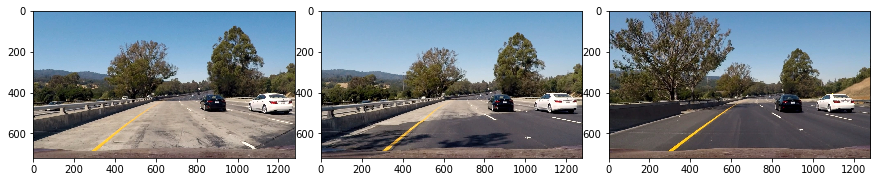

In [13]:
test_image_paths = glob.glob('test_images/*.jpg')
test_images = []
for test_image_path in test_image_paths:
        test_images.append(read_mpimg(test_image_path))
        
fig, axs = plt.subplots(1, 3, figsize=(15, 10))
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()
axs[0].imshow(test_images[0])
axs[1].imshow(test_images[3])
axs[2].imshow(test_images[5])

### Step 3.2 - Run Sliding search on test images

In [14]:
def run_sliding_window_test(scales, threshold):
    display_images = []
    num_random_images = len(test_images)
    for random_test_image in test_images:
        final_all_boxes, final_car_boxes = run_sliding_window(scales, random_test_image, 
                          final_svc, X_scaler, final_orient,
                          final_pix_per_cell, final_cell_per_block,
                          final_cspace, hog_channel=final_hog_channel,
                          spatial_transform=final_spatial_transform,
                          spatial_size=final_spatial_size, hist_transform=final_hist_transform,
                          hist_bins=final_hist_bins)
            
        out_img = draw_bounding_boxes(random_test_image, final_all_boxes, color=(0,0,255))
        out_img = draw_bounding_boxes(out_img, final_car_boxes, color=(0,255,0))
        heat = np.zeros_like(random_test_image[:,:,0]).astype(np.float)
        heatmap = add_heat(heat, final_car_boxes)
        heatmap_thr = apply_threshold(heatmap, threshold)
        labels = get_labels(heatmap_thr)
        box_image = draw_labeled_bboxes(random_test_image, labels)

        display_images.append(random_test_image)
        display_images.append(out_img)
        display_images.append(heatmap)
        display_images.append(heatmap_thr)        
        display_images.append(box_image)

    fig, axs = plt.subplots(num_random_images, 5, figsize=(15, 20))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    for i in range(num_random_images * 5):
        if i % 5 == 0:
            axs[i].set_title("Original image")
            axs[i].imshow(display_images[i])
        if i % 5 == 1:
            axs[i].set_title("Sliding windows")
            axs[i].imshow(display_images[i])
        if i % 5 == 2:
            axs[i].set_title("Heatmap")
            axs[i].imshow(display_images[i])
        if i % 5 == 3:
            axs[i].set_title("Heatmap Thr")
            axs[i].imshow(display_images[i])
        if i % 5 == 4:
            axs[i].set_title("Detected Cars") 
            axs[i].imshow(display_images[i])

Just running one scale (430, 680, 2)


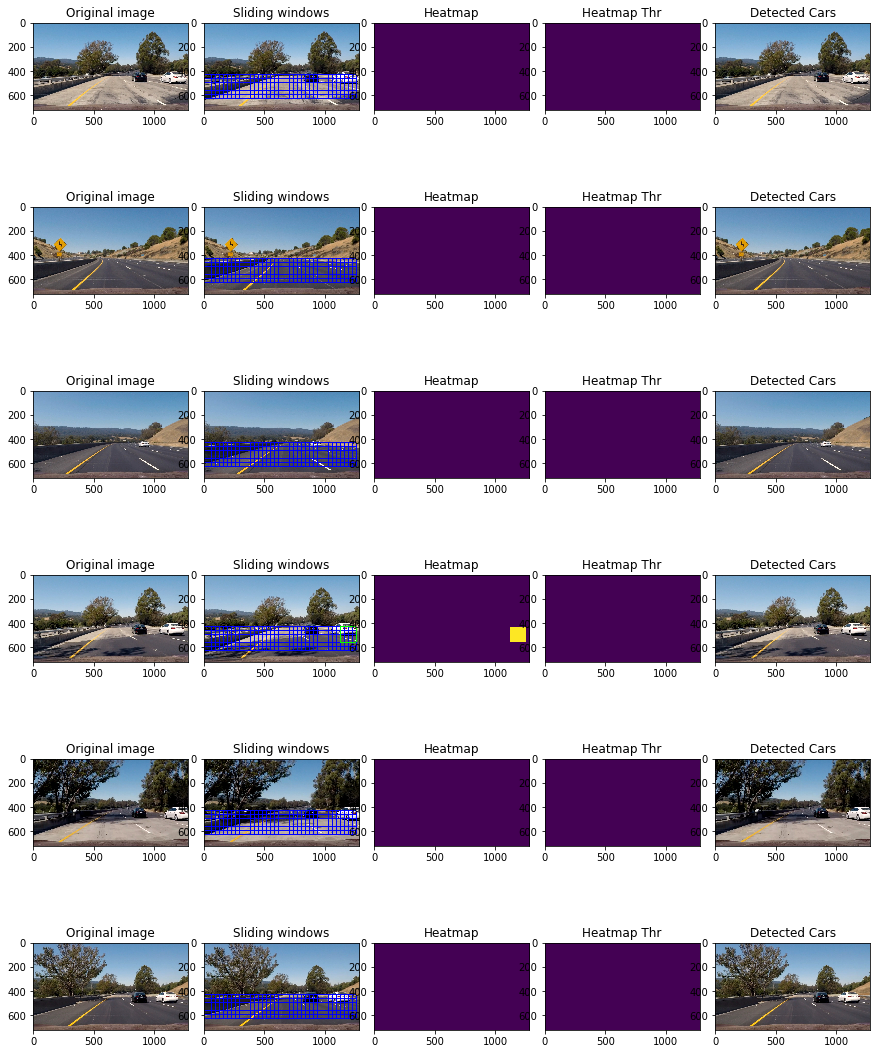

In [24]:
# At bottom of image, cars are bigger. Try bigger scale
print("Just running one scale (430, 680, 2)")
run_sliding_window_test([(430, 680, 2)], 1)

Just running one scale (400, 610, 1.75)


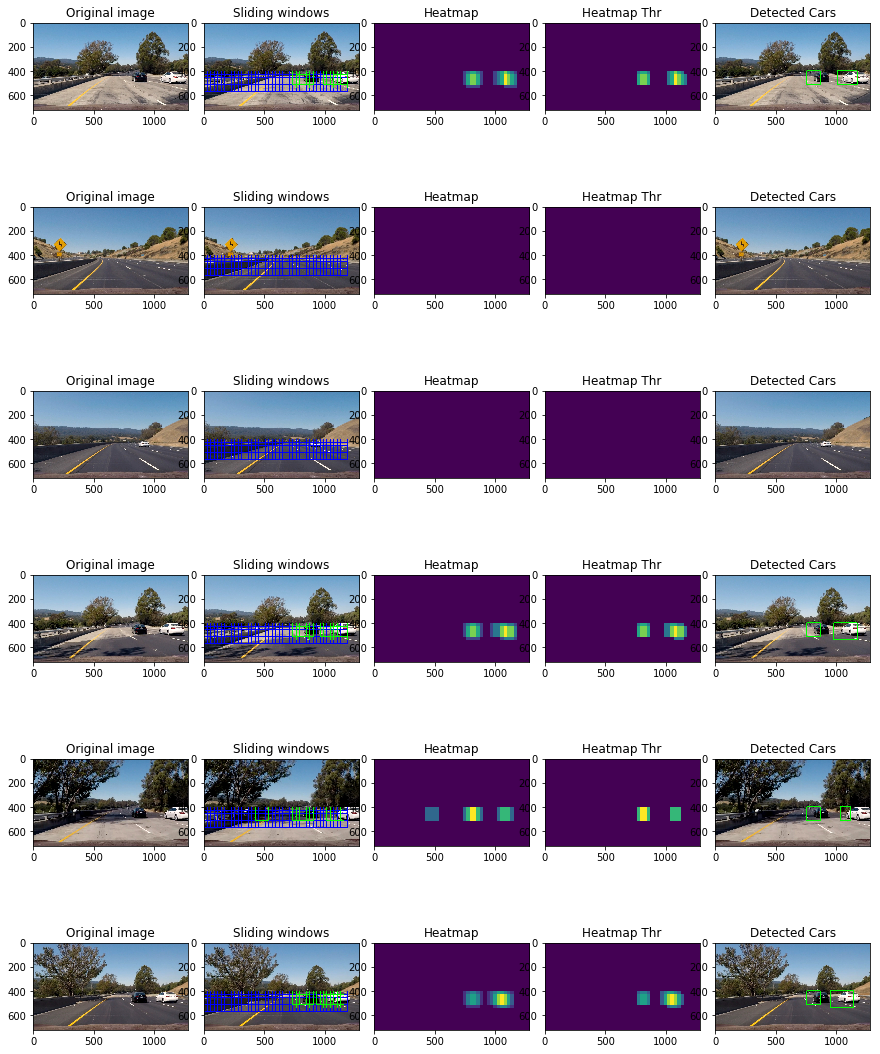

In [13]:
# At slighly mid range, cars are mid-size (in picture). Try smaller scale
print("Just running one scale (400, 610, 1.75)")
run_sliding_window_test([(400, 610, 1.75)], 1)

Just running one scale (360, 560, 1.5)


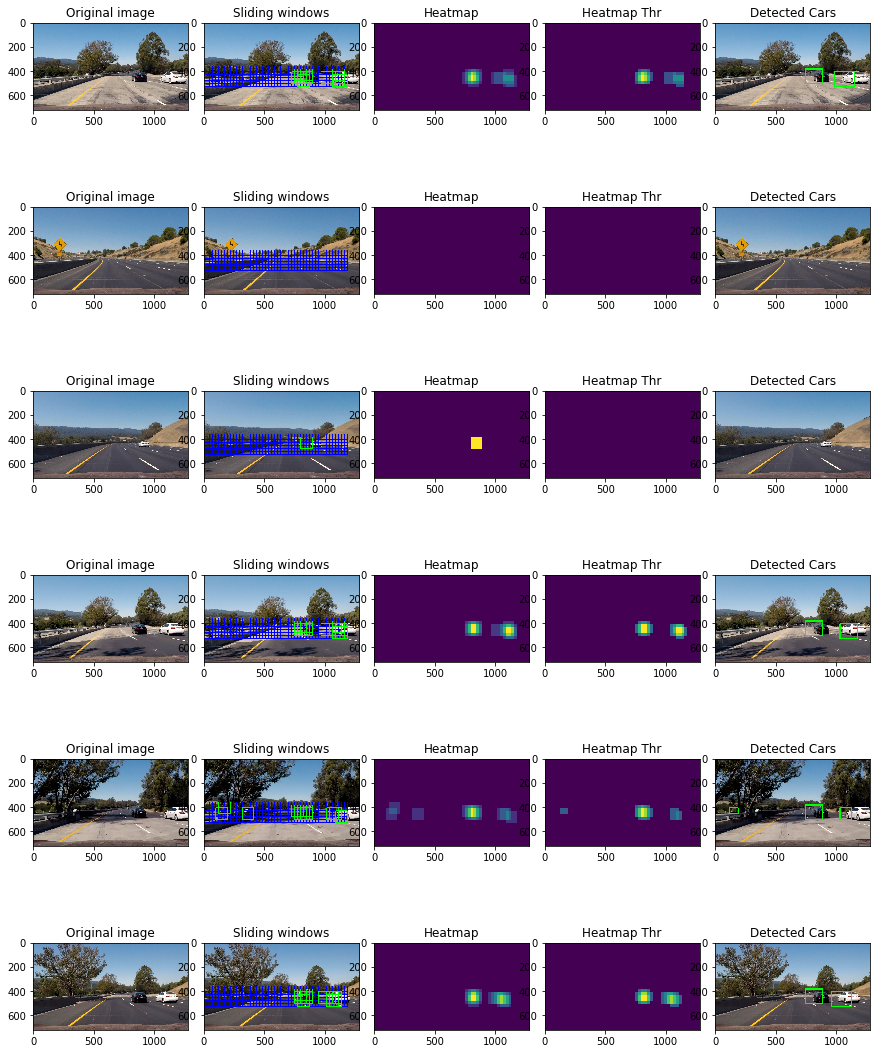

In [14]:
# At mid to top, cars are tiny (in picture). Try smaller scale
print("Just running one scale (360, 560, 1.5)")
run_sliding_window_test([(360, 560, 1.5)], 1)

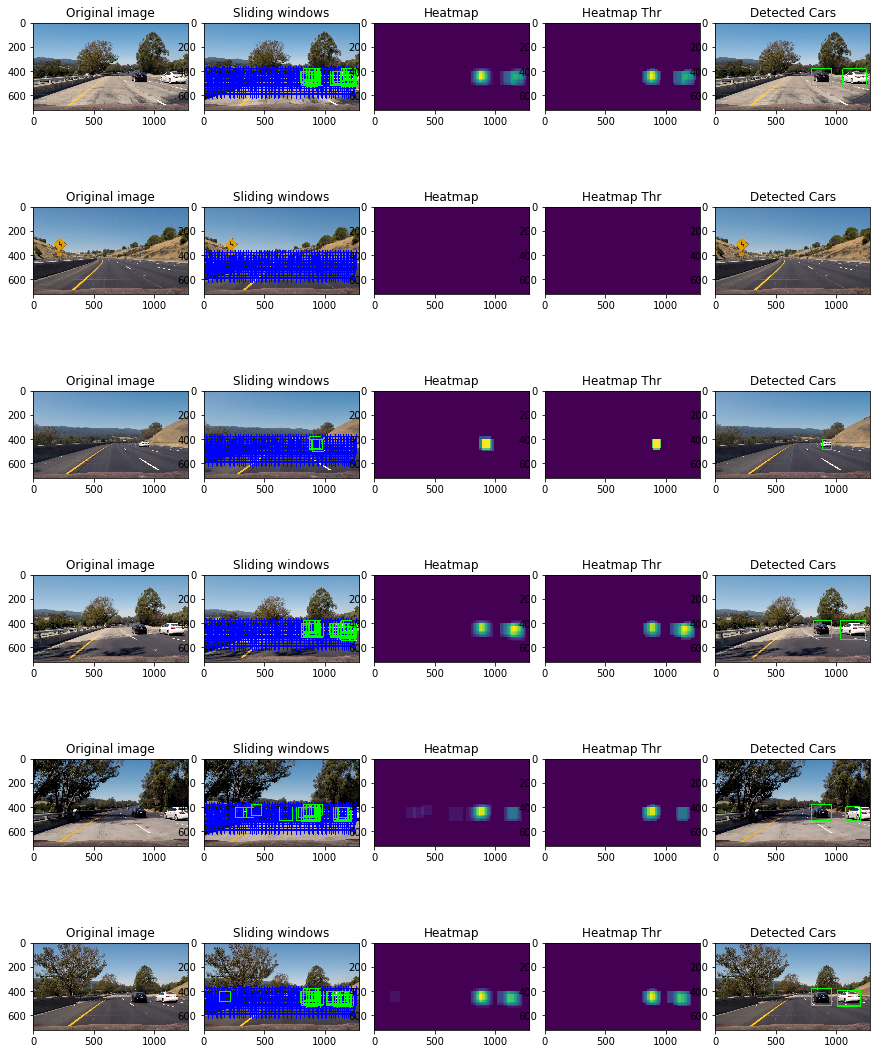

In [38]:
# Run combination of all them
run_sliding_window_test([(360, 520, 1.35), (380, 550, 1.5), 
                       (400, 600, 1.75), (400, 600, 1.85), 
                       (450, 680, 2.25), (450, 680, 2.15)], 2)

## Step 3.3 Define Final scales

In [51]:
final_scales = [(360, 520, 1.35), (380, 550, 1.5), 
                       (400, 600, 1.75), (400, 600, 1.85), 
                       (450, 680, 2.25), (450, 680, 2.15)]

At this point, I have completed tuning all paremeters I need. Here are list of transformation parameters and scales

- cspace='YUV'
- spatial_transform=True
- spatial_size=(16, 16)
- hist_transform=True
- hist_bins= 32
- orient= 11
- pix_per_cell= 8
- cell_per_block= 2
- hog_channel= 'ALL'
- scales = [(360, 520, 1.35), (380, 550, 1.5), 
           (400, 600, 1.75), (400, 600, 1.85), 
           (450, 680, 2.25), (450, 680, 2.15)]

## Step 4 - Define a Pipeline class

In [47]:
class Pipeline():
    """
        Class to process each frame in video
    """
    def __init__(self):
        self.cspace = 'YUV'
        self.spatial_transform = True
        self.spatial_size=(16, 16)
        self.hist_transform = True
        self.hist_bins = 32
        self.hog_transform = True
        self.orient = 11
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        self.scales = [(360, 520, 1.35), (380, 550, 1.5), 
                       (400, 600, 1.75), (400, 600, 1.85), 
                       (450, 680, 2.25), (450, 680, 2.15)]
        self.threshold = 1
        self.svc = None
        self.X_scaler = None
        self.prev_labels = []
        # We will be storing boxes of previous 15 boxes
        self.frame_look_back = 15
        self.all_frames_boxes = []

        self.heatmaps = []
        self.heatmap_look_back = 5
        self.frames = []
        
    def run_training(self):
        ## Load model params
        with open('svc-params.pk', 'rb') as pfile:
            pickle_data = pickle.load(pfile)
            self.svc = pickle_data.get('svc', None)
            self.X_scaler = pickle_data.get('X_scaler', None)

        if self.svc is not None:
            print("Loaded Model from Pickle file")
            return
        
        vehicle_paths = glob.glob('dataset/vehicles/**/*.png')
        non_vehicle_paths =  glob.glob('dataset/non-vehicles/**/*.png')
            
        vehicle_images = []
        non_vehicle_images = []

        for i in range(len(vehicle_paths)):
                vehicle_images.append(read_mpimg(vehicle_paths[i]))

        for i in range(len(non_vehicle_paths)):
                non_vehicle_images.append(read_mpimg(non_vehicle_paths[i]))

        self.svc, _, _, self.X_scaler = training_pipeline(
                     vehicle_images, non_vehicle_images,
                     cspace=self.cspace, 
                     spatial_size=self.spatial_size,
                     spatial_transform=self.spatial_transform, 
                     hist_transform=self.hist_transform, 
                     hist_bins=self.hist_bins,
                     hog_transform=self.hog_transform, 
                     pix_per_cell=self.pix_per_cell, 
                     cell_per_block=self.cell_per_block, 
                     orient=self.orient, 
                     hog_channel=self.hog_channel)
    
    def add_frame_boxes(self, car_boxes):
        self.all_frames_boxes.append(car_boxes)
        if len(self.all_frames_boxes) > self.frame_look_back:
            self.all_frames_boxes.pop(0)
    
    def add_current_heatmap(self, frame, heatmap):
        self.frames.append(frame)
        self.heatmaps.append(heatmap)
        if len(self.heatmaps) > self.heatmap_look_back:
            self.heatmaps.pop(0)
            self.frames.pop(0)
    
    def process_frame_with_bbox_avg(self, img):
        all_boxes, car_boxes = run_sliding_window(self.scales, img, 
                          self.svc, self.X_scaler, self.orient,
                          self.pix_per_cell, self.cell_per_block,
                          self.cspace, hog_channel=self.hog_channel,
                          spatial_transform=self.spatial_transform,
                          spatial_size=self.spatial_size,
                          hist_transform=self.hist_transform,
                          hist_bins=self.hist_bins)    

        self.add_frame_boxes(car_boxes)
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        
        for f_car_boxes in self.all_frames_boxes:
            heatmap = add_heat(heatmap, f_car_boxes)
            
        # Threshold should be self.threshold for current frame and few the previous frames should have this box
        heatmap_thr = apply_threshold(heatmap, self.threshold + int(len(self.all_frames_boxes) * 0.7))
        
        return heatmap_thr
    
        
    def process_frame_with_heatmap_avg(self, img):
        all_boxes, car_boxes = run_sliding_window(self.scales, img, 
                          self.svc, self.X_scaler, self.orient,
                          self.pix_per_cell, self.cell_per_block,
                          self.cspace, hog_channel=self.hog_channel,
                          spatial_transform=self.spatial_transform,
                          spatial_size=self.spatial_size,
                          hist_transform=self.hist_transform,
                          hist_bins=self.hist_bins)    
        
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        heatmap = add_heat(heatmap, car_boxes)
        
#         if self.current_heatmap is None:
#             self.current_heatmap = heatmap
#         else:
#             self.current_heatmap = self.new_frame_factor * heatmap + (1-self.new_frame_factor) * self.current_heatmap
        
#         # Threshold should be self.threshold for current frame and few the previous frames should have this box
#         heatmap_thr = apply_threshold(self.current_heatmap, 
#                                       self.threshold)

        # Maintain a running average of previous few frames
        if len(self.heatmaps) > 0:
            # Make a copy of previous heatmaps
            prev_heatmaps = self.heatmaps[:]
            # Append current heatmaps
            prev_heatmaps.append(heatmap)
            # New heatmaps is average of all these heatmaps
            heatmap = np.sum(np.array(prev_heatmaps), axis=0) / len(prev_heatmaps)
            
        # Finally enqueue current heatmaps to history of heatmaps
        self.add_current_heatmap(np.copy(img), heatmap)
        
        heatmap_thr = apply_threshold(heatmap, self.threshold)
        
        return heatmap_thr
        
    def process_frame(self, img):
        if self.svc == None:            
            self.run_training()
        
        heatmap_thr = self.process_frame_with_heatmap_avg(img)
        
        labels = get_labels(heatmap_thr)
        box_image = draw_labeled_bboxes(img, labels, size=6)        
        return box_image
        

### Step 4.1 Test pipeline on a single image

In [48]:
test_pipeline = Pipeline()

project_video = VideoFileClip('test_video.mp4')
out_frames = project_video.fl_image(test_pipeline.process_frame)
%time out_frames.write_videofile('test_video_out.mp4', audio=False)

Loaded Model from Pickle file
[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:35<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 33.8 s, sys: 2.43 s, total: 36.2 s
Wall time: 36.9 s


In [50]:
project_pipeline = Pipeline()
# project_video = VideoFileClip('project_video.mp4').subclip(25, 31)
project_video = VideoFileClip('project_video.mp4')
out_frames = project_video.fl_image(project_pipeline.process_frame)
%time out_frames.write_videofile('project_video_out.mp4', audio=False)


Loaded Model from Pickle file
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [26:59<00:01,  1.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 25min 35s, sys: 1min 40s, total: 27min 15s
Wall time: 27min
